In [1]:
%load_ext autoreload
%autoreload 2
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
from taigapy import create_taiga_client_v3
from scipy.stats import pearsonr
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA, FastICA, NMF
tc = TaigaClient()

# Load dataset

In [2]:
%%capture

OmicsExpressionAllGenesEffectiveLengthProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesEffectiveLengthProfile')
OmicsExpressionAllGenesTPMLogp1Profile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesTPMLogp1Profile')
OmicsExpressionGenesExpectedCountProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionGenesExpectedCountProfile')
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')
OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')

In [3]:
OmicsExpressionProteinCodingGenesTPMLogp1 = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionProteinCodingGenesTPMLogp1')

In [4]:
tc = create_taiga_client_v3()
df_gene_effect = tc.get('internal-23q4-ac2b.68/CRISPRGeneEffect')

In [5]:
df_gene_effect.columns = df_gene_effect.columns.map(lambda x:x.split()[0])

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_10384/4161618012.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gene_effect.loc[:, "PITX2"])


<Axes: xlabel='PITX2', ylabel='Density'>

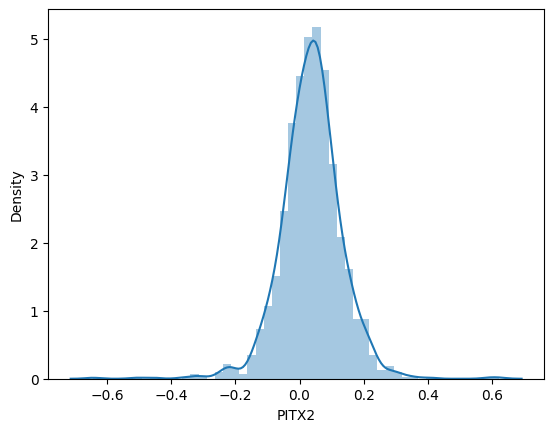

In [6]:
sns.distplot(df_gene_effect.loc[:, "PITX2"])

# Calculate raw TPM

In [7]:
def calculate_tpm(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape

    denom = counts_df.sum(axis=1)
    denom = denom.where(denom > 1e-300, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > 1e-300, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > 1e-300, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return tpm_df

In [8]:
profile_to_model_dict = OmicsDefaultModelProfiles.query("ProfileType == 'rna'").\
        set_index("ProfileID").\
        drop("ProfileType", axis=1).\
        to_dict()["ModelID"]

In [9]:
mybiomart = helper.generateGeneNames(ensemble_server="http://nov2020.archive.ensembl.org/biomart", useCache=False)
protcod_rename = {}
for _, i in mybiomart[
    (~mybiomart.entrezgene_id.isna()) & (mybiomart.gene_biotype == "protein_coding")
].iterrows():
    if i.ensembl_gene_id not in protcod_rename:
        protcod_rename.update(
            {
                i.hgnc_symbol + " (" + i.ensembl_gene_id + ")": i.hgnc_symbol
                + " ("
                + str(int(i.entrezgene_id))
                + ")"
            }
        )

downloading gene names from biomart


In [10]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes = OmicsExpressionAllGenesEffectiveLengthProfile.loc[:, OmicsExpressionGenesExpectedCountProfile.columns]

In [11]:
expected_counts = OmicsExpressionGenesExpectedCountProfile
expected_counts.columns = OmicsExpressionGenesExpectedCountProfile.columns.map(protcod_rename)
expected_counts = expected_counts.loc[:, ~expected_counts.columns.isnull()]

In [12]:
effected_len = OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes
effected_len.columns = OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes.columns.map(protcod_rename)
effected_len = effected_len.loc[:, ~effected_len.columns.isnull()]

In [13]:
expected_counts.shape, effected_len.shape

((1904, 19193), (1904, 19193))

In [14]:
raw_tpm = calculate_tpm(expected_counts, effected_len)

0
0
0
0
0


In [15]:
raw_tpm.loc[:, "Model"] = raw_tpm.index.map(profile_to_model_dict)
raw_tpm = raw_tpm.set_index("Model")
raw_tpm = raw_tpm.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

In [16]:
raw_tpm.head()

TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
ACH-001113      20.526962      0.000000   175.666728       6.360556   
ACH-001289      23.742405      0.522378   143.074954       5.049324   
ACH-001339       8.149281      0.000000   171.193332       4.177226   
ACH-001979      19.051605      0.000000    53.541772       3.380289   
ACH-002438      15.880885      0.000000   104.616165       3.449039   

            C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  \
ACH-001113         22.709076    0.022054    1.441308      7.770455   
ACH-001289         10.821839    0.000000    0.146028     13.659763   
ACH-001339         18.348290    0.039311    1.533805    105.580382   
ACH-001979          2.257849    0.000000  159.405711     64.655063   
ACH-002438          7.259670    0.000000    3.615014    117.303832   

            GCLC (2729)  NFYA (4800)  ...  H3C2 (8358)  H3C3 (8352)  \
ACH-001113    95.985117    27.586337  ...     5.842860     0.146074   
ACH-001289    18.462946    10.632261  ...     1.502191     1.118475   
ACH-001339    12.249465     8.967880  ...     0.524866     1.180149   
ACH-001979    24.691353     6.984800  ...     0.000000     0.000000   
ACH-002438     8.826829    19.013307  ...     0.184360     0.308984   

            AC098582.1 (8916)  DUS4L-BCAP29 (115253422)  \
ACH-001113           0.159985                  3.627486   
ACH-001289           0.256480                  1.837610   
ACH-001339           0.808435                  6.943878   
ACH-001979           0.856591                  2.868616   
ACH-002438           0.515836                  2.441925   

            C8orf44-SGK3 (100533105)  ELOA3B (728929)  NPBWR1 (2831)  \
ACH-001113                  0.506324              0.0       0.229611   
ACH-001289                  0.574309              0.0       0.014282   
ACH-001339                  0.406050              0.0       0.060121   
ACH-001979                  0.139157              0.0       0.004697   
ACH-002438                  0.820870              0.0       0.010139   

            ELOA3D (100506888)  ELOA3 (162699)  CDR1 (1038)  
ACH-001113                 0.0             0.0     0.000000  
ACH-001289                 0.0             0.0     0.000000  
ACH-001339                 0.0             0.0     0.034487  
ACH-001979                 0.0             0.0     0.000000  
ACH-002438                 0.0             0.0     0.029057  

[5 rows x 19193 columns]

In [17]:
old_mean_exp = raw_tpm.iloc[:, :-1].median(axis=1)

old_tpm_correlation_list = []
for gene in raw_tpm.columns[:-1]:
    old_tpm_correlation_list.append(pearsonr(old_mean_exp, raw_tpm.loc[:, gene])[0])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          1.,   1.,   0.,   3.,   4.,   1.,   3.,   3.,   0.,   1.,   2.,
          2.,   2.,   2.,   2.,   2.,   0.,   4.,   1.,   2.,   3.,   3.,
          1.,   0.,   0.,   2.,   6.,   0.,   1.,   1.,   0.,   1.,   1.,
          0.,   1.,   4.,   1.,   0.,   0.,   0.,   1.,   1.,   4.,   0.,
          0.,   3.,   1.,   0.,   1.,   2.,   3.,   2.,   2.,   3.,   2.,
          4.,   4.,   6.,   3.,   6.,   4.,   9.,   6.,  11.,   9.,  12.,
          7.,  10.,   8.,   3.,   6.,  13.,  11.,  13.,   9.,  12.,   1.,
         16.,  11.,  10.,  10.,  14.,  15.,  17.,  19.,  21.,   9.,  21.,
         21.,  23.,  25.,  23.,  19.,  26.,  37.,  30.,  24.,  36.,  36.,
         42.,  51.,  34.,  52.,  52.,  72.,  81., 101.,  96., 104., 124.,
        125., 130., 139., 152., 173., 159., 191., 193., 173., 202., 196.,
        183., 201., 233., 187., 252., 195., 204., 173., 195., 215., 191.,
        174., 155., 203., 136., 169., 

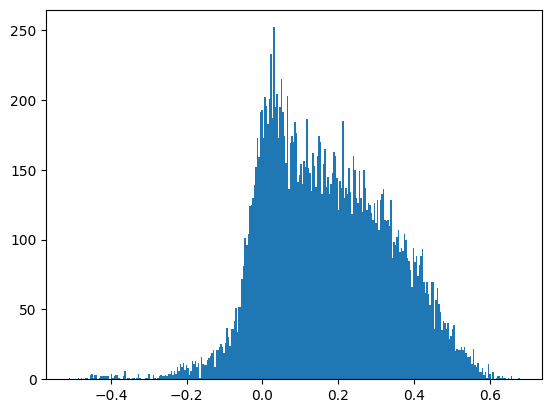

In [18]:
plt.hist(old_tpm_correlation_list, bins=300)

# Quantile Normalization

In [19]:
raw_tpm_copy = raw_tpm.copy().T

In [20]:
def quant_norm1(df):
    ranks = (df.rank(method="first")
              .stack())
    rank_mean = (df.stack()
                   .groupby(ranks)
                   .mean())
    print(rank_mean.head())
    print(rank_mean.tail())

    return (df.rank(method='min')
             .stack()
             .astype(int)
             .map(rank_mean)
             .unstack())

In [21]:
def quant_norm2(df):
    ranks = (df.rank(method="first")
              .stack())
    rank_mean = (df.stack()
                   .groupby(ranks)
                   .mean())
    print(rank_mean.head())
    print(rank_mean.tail())

    # Add interpolated values in between ranks
    finer_ranks = ((rank_mean.index+0.5).to_list() +
                    rank_mean.index.to_list())
    print(len(finer_ranks))
    print(len(finer_ranks))

    rank_mean = rank_mean.reindex(finer_ranks).sort_index().interpolate()
    print(rank_mean.head())
    print(rank_mean.tail())
    return (df.rank(method='average')
              .stack()
              .map(rank_mean)
              .unstack())

In [22]:
# raw_tpm_copy = quant_norm1(raw_tpm_copy)

In [23]:
raw_tpm_copy = quant_norm2(raw_tpm_copy)

1.0    0.0
2.0    0.0
3.0    0.0
4.0    0.0
5.0    0.0
dtype: float64
19189.0    16347.327426
19190.0    18496.411635
19191.0    21248.354106
19192.0    25916.754038
19193.0    47241.614074
dtype: float64
38386
38386
1.0    0.0
1.5    0.0
2.0    0.0
2.5    0.0
3.0    0.0
dtype: float64
19191.5    23582.554072
19192.0    25916.754038
19192.5    36579.184056
19193.0    47241.614074
19193.5    47241.614074
dtype: float64


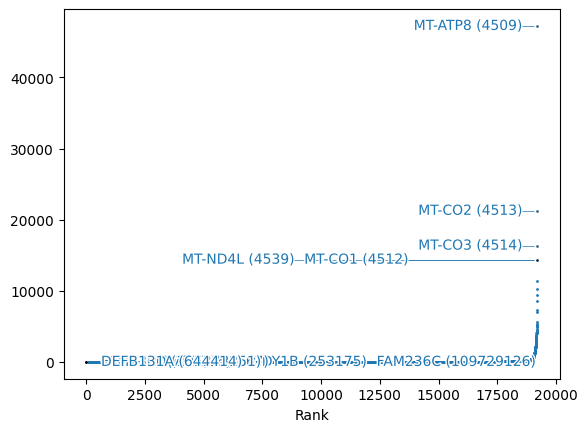

In [24]:
new_sample_median_expression = raw_tpm_copy.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

In [25]:
# chrM_labels = raw_tpm_copy.columns[raw_tpm_copy.columns.str.contains("^MT-")]
# fig, ax = plt.subplots()
# fig.set_size_inches(8, 5)
# plotting.density_scatter(raw_tpm_copy.loc[:, :].median(axis=1),
#                          raw_tpm_copy.loc[:, chrM_labels].median(axis=1),
#                          ax=ax)
# ax.set_ylabel("Mitochondrial median expression")
# ax.set_xlabel("All gene median expression")

# fig, ax = plt.subplots()
# fig.set_size_inches(8, 5)
# plotting.density_scatter(raw_tpm_copy.loc[:, :].median(axis=1),
#                          raw_tpm_copy.loc[:, chrM_labels].median(axis=1),
#                          ax=ax)
# ax.set_ylabel("Mitochondrial median expression")
# ax.set_xlabel("All gene median expression")

In [26]:
raw_tpm_copy = raw_tpm_copy.T

In [27]:
raw_tpm_copy.head()

TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
ACH-001113      17.416861      0.000041   159.931814       5.158212   
ACH-001289      21.398286      0.555614   117.522439       4.786898   
ACH-001339       9.076940      0.000027   152.998605       4.643071   
ACH-001979      23.363881      0.000338    60.591167       5.066298   
ACH-002438      16.642060      0.000154    97.330763       3.511509   

            C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  \
ACH-001113         19.332535    0.017263    1.058297      6.305254   
ACH-001289          9.938277    0.000043    0.157840     12.450694   
ACH-001339         19.728055    0.034067    1.817992     97.476120   
ACH-001979          3.636843    0.000338  161.769723     71.508057   
ACH-002438          7.582847    0.000154    3.686213    107.925560   

            GCLC (2729)  NFYA (4800)  ...  H3C2 (8358)  H3C3 (8352)  \
ACH-001113    88.032396    23.905696  ...     4.807608     0.094461   
ACH-001289    16.719879     9.792638  ...     1.504714     1.152850   
ACH-001339    13.364847     9.905601  ...     0.624040     1.391008   
ACH-001979    29.610335     9.312575  ...     0.000338     0.000338   
ACH-002438     9.365751    20.012370  ...     0.247008     0.387820   

            AC098582.1 (8916)  DUS4L-BCAP29 (115253422)  \
ACH-001113           0.102677                  2.839342   
ACH-001289           0.279160                  1.812299   
ACH-001339           0.958446                  7.697868   
ACH-001979           1.785866                  4.444425   
ACH-002438           0.603535                  2.453337   

            C8orf44-SGK3 (100533105)  ELOA3B (728929)  NPBWR1 (2831)  \
ACH-001113                  0.351378         0.000041       0.152722   
ACH-001289                  0.606534         0.000043       0.016418   
ACH-001339                  0.469391         0.000027       0.057770   
ACH-001979                  0.405024         0.000338       0.045983   
ACH-002438                  0.906495         0.000154       0.036960   

            ELOA3D (100506888)  ELOA3 (162699)  CDR1 (1038)  
ACH-001113            0.000041        0.000041     0.000041  
ACH-001289            0.000043        0.000043     0.000043  
ACH-001339            0.000027        0.000027     0.028497  
ACH-001979            0.000338        0.000338     0.000338  
ACH-002438            0.000154        0.000154     0.062401  

[5 rows x 19193 columns]

In [28]:
old_mean_exp = raw_tpm_copy.median(axis=1)

old_tpm_correlation_list = []
for gene in raw_tpm_copy.columns:
    old_tpm_correlation_list.append(pearsonr(old_mean_exp, raw_tpm_copy.loc[:, gene])[0])

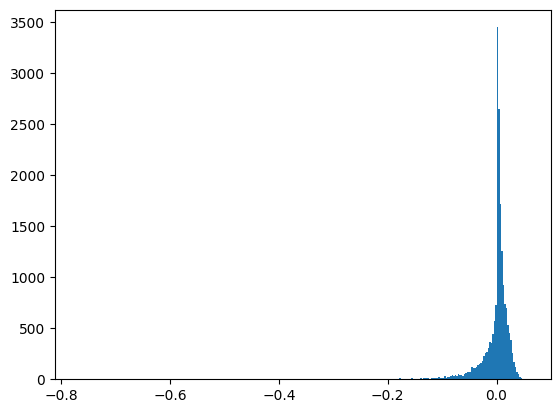

In [29]:
_ = plt.hist(old_tpm_correlation_list, bins=300)

In [30]:
import pandas as pd
model_dataset = pd.read_csv("~/23Q4_model.csv", index_col=0)

In [31]:
patterns = []
amplitudes = []
for norm_gene_expression in [np.sqrt(raw_tpm_copy), np.log1p(raw_tpm_copy), raw_tpm_copy]:
    ica_model = FastICA(n_components=100,
                        random_state=99,
                        whiten='unit-variance')

    nmf_model = NMF(n_components=100, init='random',
                    random_state=99)

    pca_model = PCA(n_components=100,
                    random_state=99,
                    whiten=True)

    ica_X_transformed = ica_model.fit_transform(norm_gene_expression)
    A = ica_model.mixing_

    patterns.append(ica_X_transformed)
    amplitudes.append(A)

    W = nmf_model.fit_transform(norm_gene_expression)
    H = nmf_model.components_
    patterns.append(W)
    amplitudes.append(H)

    pattern = pca_model.fit_transform(norm_gene_expression)
    amplitude = pca_model.components_
    patterns.append(pattern)
    amplitudes.append(amplitude)
    

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [32]:
from sklearn.linear_model import LogisticRegression

cell_line_classifier_acc = []

for index, pat in enumerate(patterns):
    # (normalized expression, 3 factorization methods)
    pat_df = pd.DataFrame(pat, columns=np.arange(100))
    pat_df.loc[:, "lineage"] = raw_tpm_copy.index.map(model_dataset.OncotreeLineage.to_dict())
    pat_df = pat_df.loc[~pat_df.lineage.isnull(), :]
    logit = LogisticRegression(random_state=999, penalty="l1", solver="liblinear")
    logit.fit(pat_df.iloc[:, :-1], pat_df.iloc[:, -1])
    cell_line_classifier_acc.append(logit.score(pat_df.iloc[:, :-1], pat_df.iloc[:, -1]))

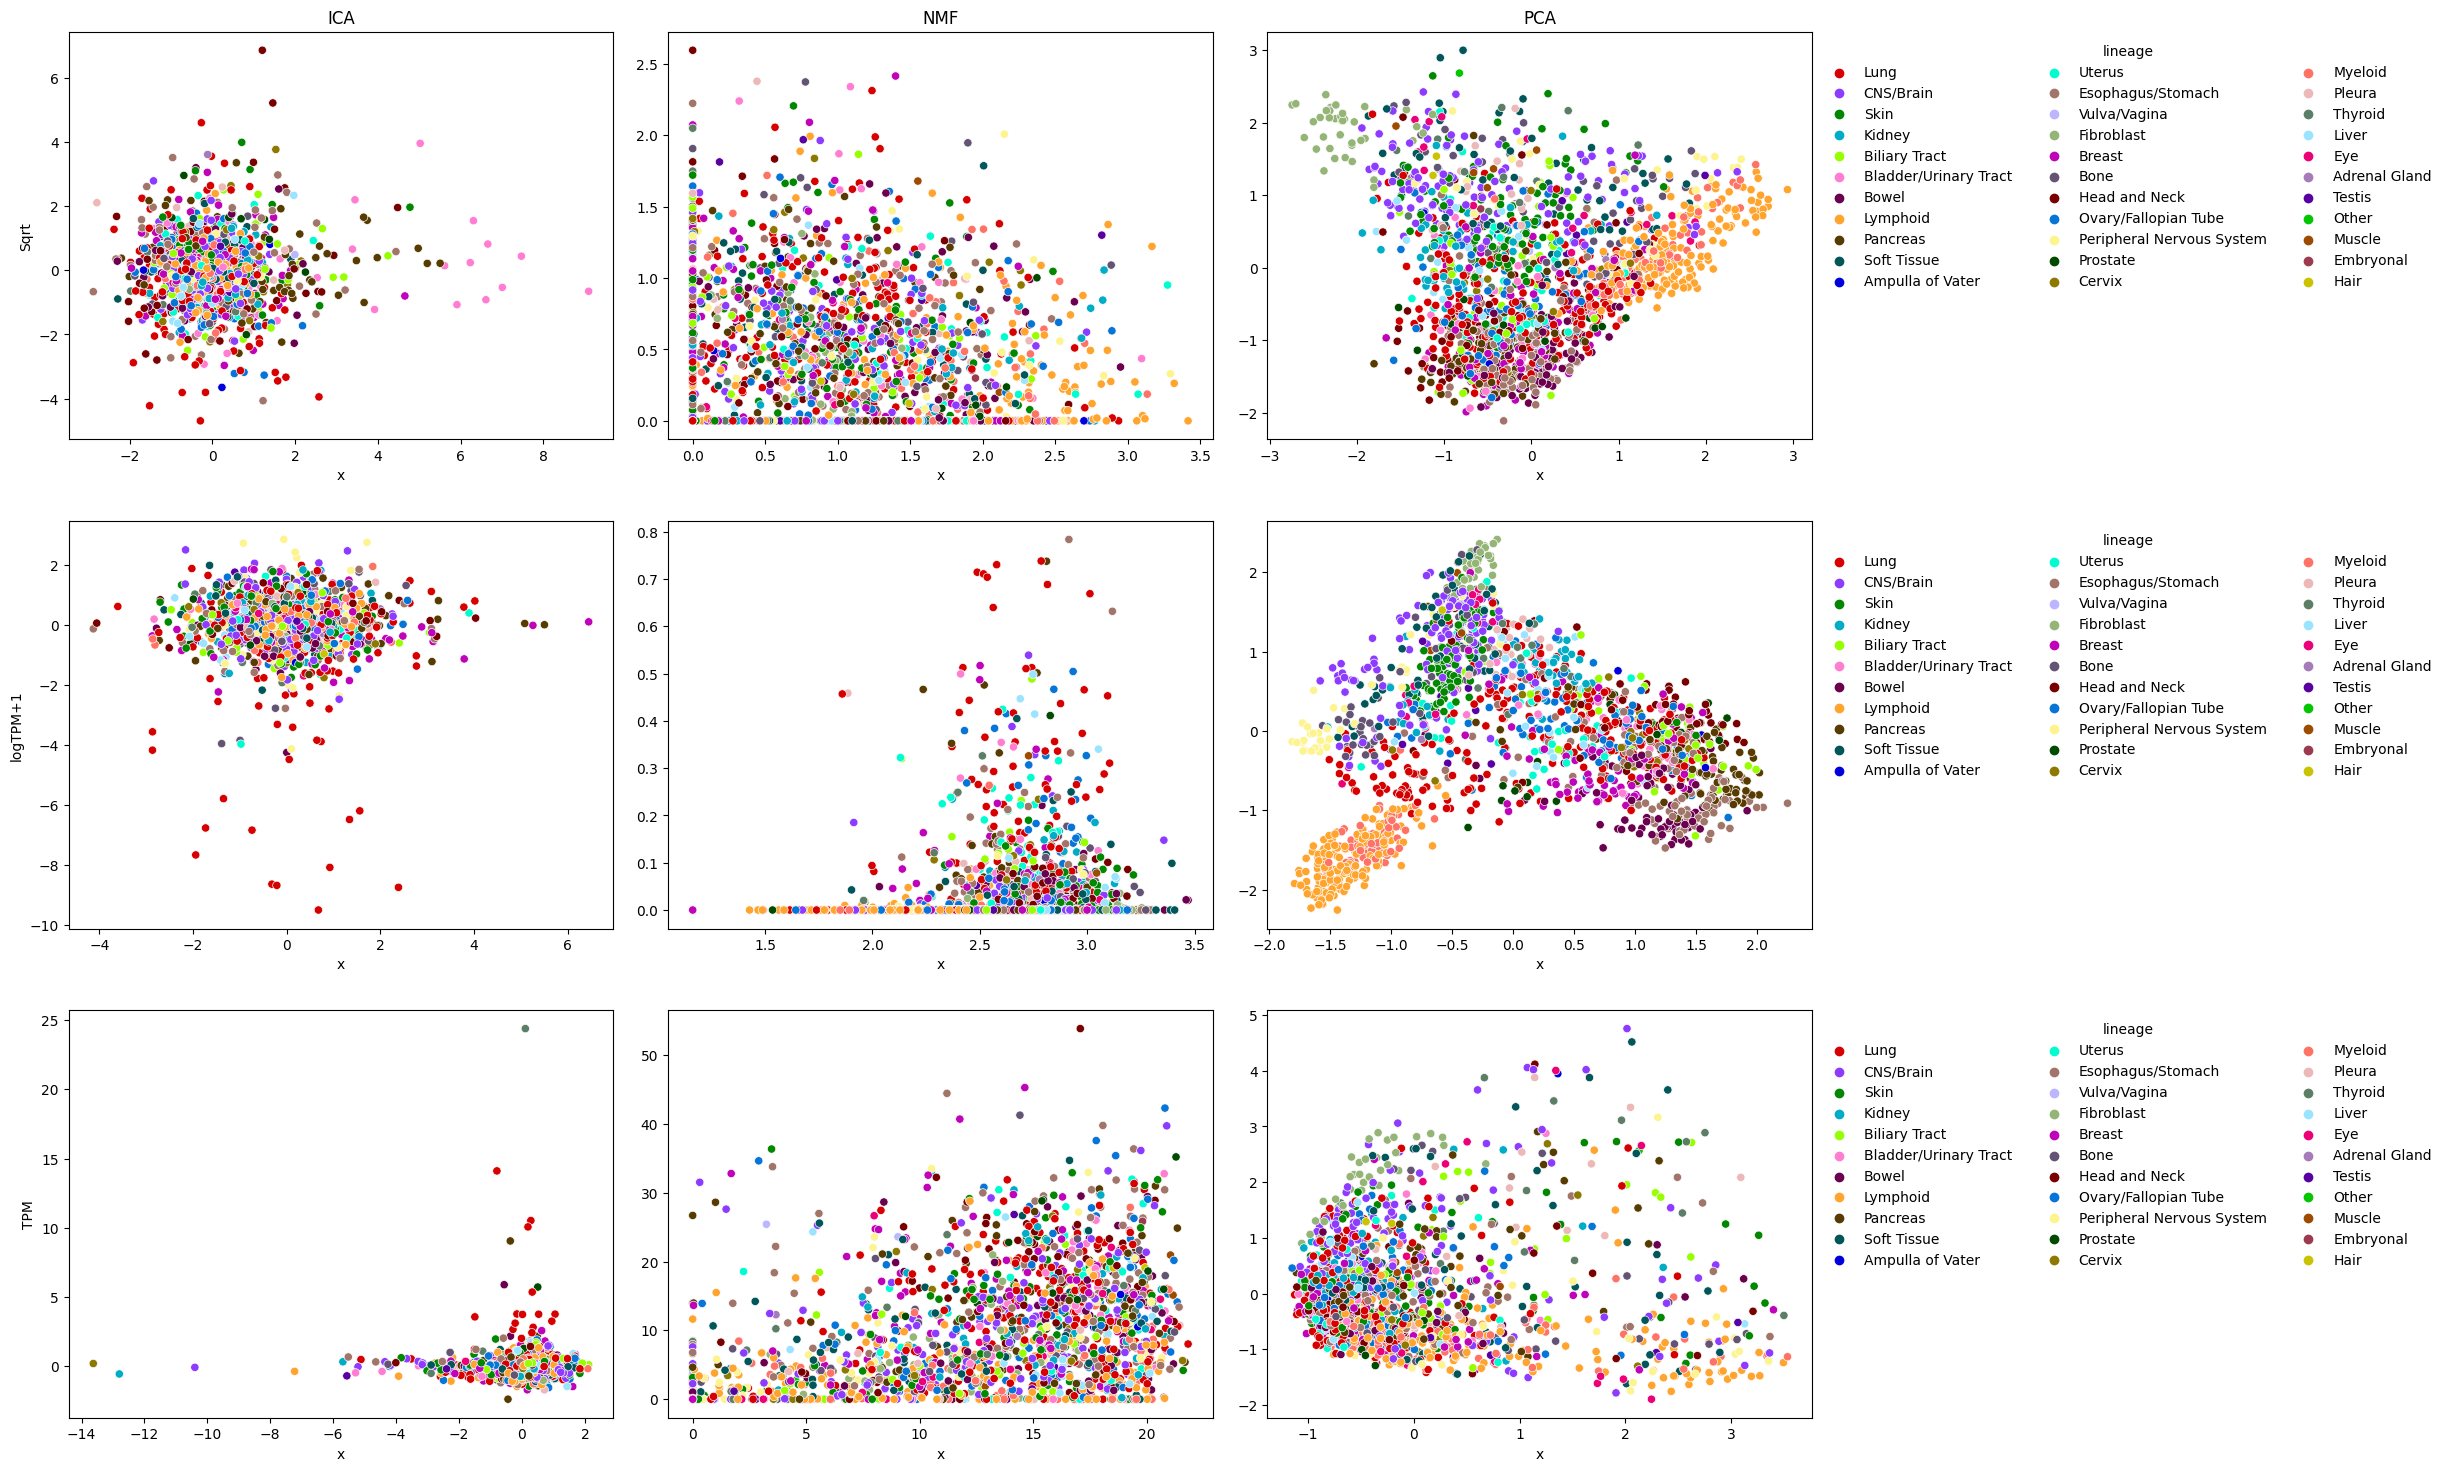

In [33]:
import colorcet as cc
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(22.5, 18)
ax = ax.flatten()
palette = sns.color_palette(cc.glasbey, n_colors=33)

ax[0].set_title("ICA")
ax[1].set_title("NMF")
ax[2].set_title("PCA")

for index, pat in enumerate(patterns):
    # (normalized expression, 3 factorization methods)
    pat_df = pd.DataFrame(dict(x=pat[:,0], y=pat[:,1],lineage=raw_tpm_copy.index.map(model_dataset.OncotreeLineage.to_dict())))
    if index % 3 <= 1:
        sns.scatterplot(pat_df, x="x", y="y", hue='lineage', ax=ax[index], legend=False, palette=palette)
    else:
        sns.scatterplot(pat_df, x="x", y="y", hue='lineage', ax=ax[index], legend='brief', palette=palette)
        sns.move_legend(ax[index], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)
    if index % 3 == 0:
        ax[index].set_ylabel(["Sqrt", "logTPM+1", "TPM"][index // 3])
    else:
        ax[index].set_ylabel("")
fig.subplots_adjust(wspace=0.1)

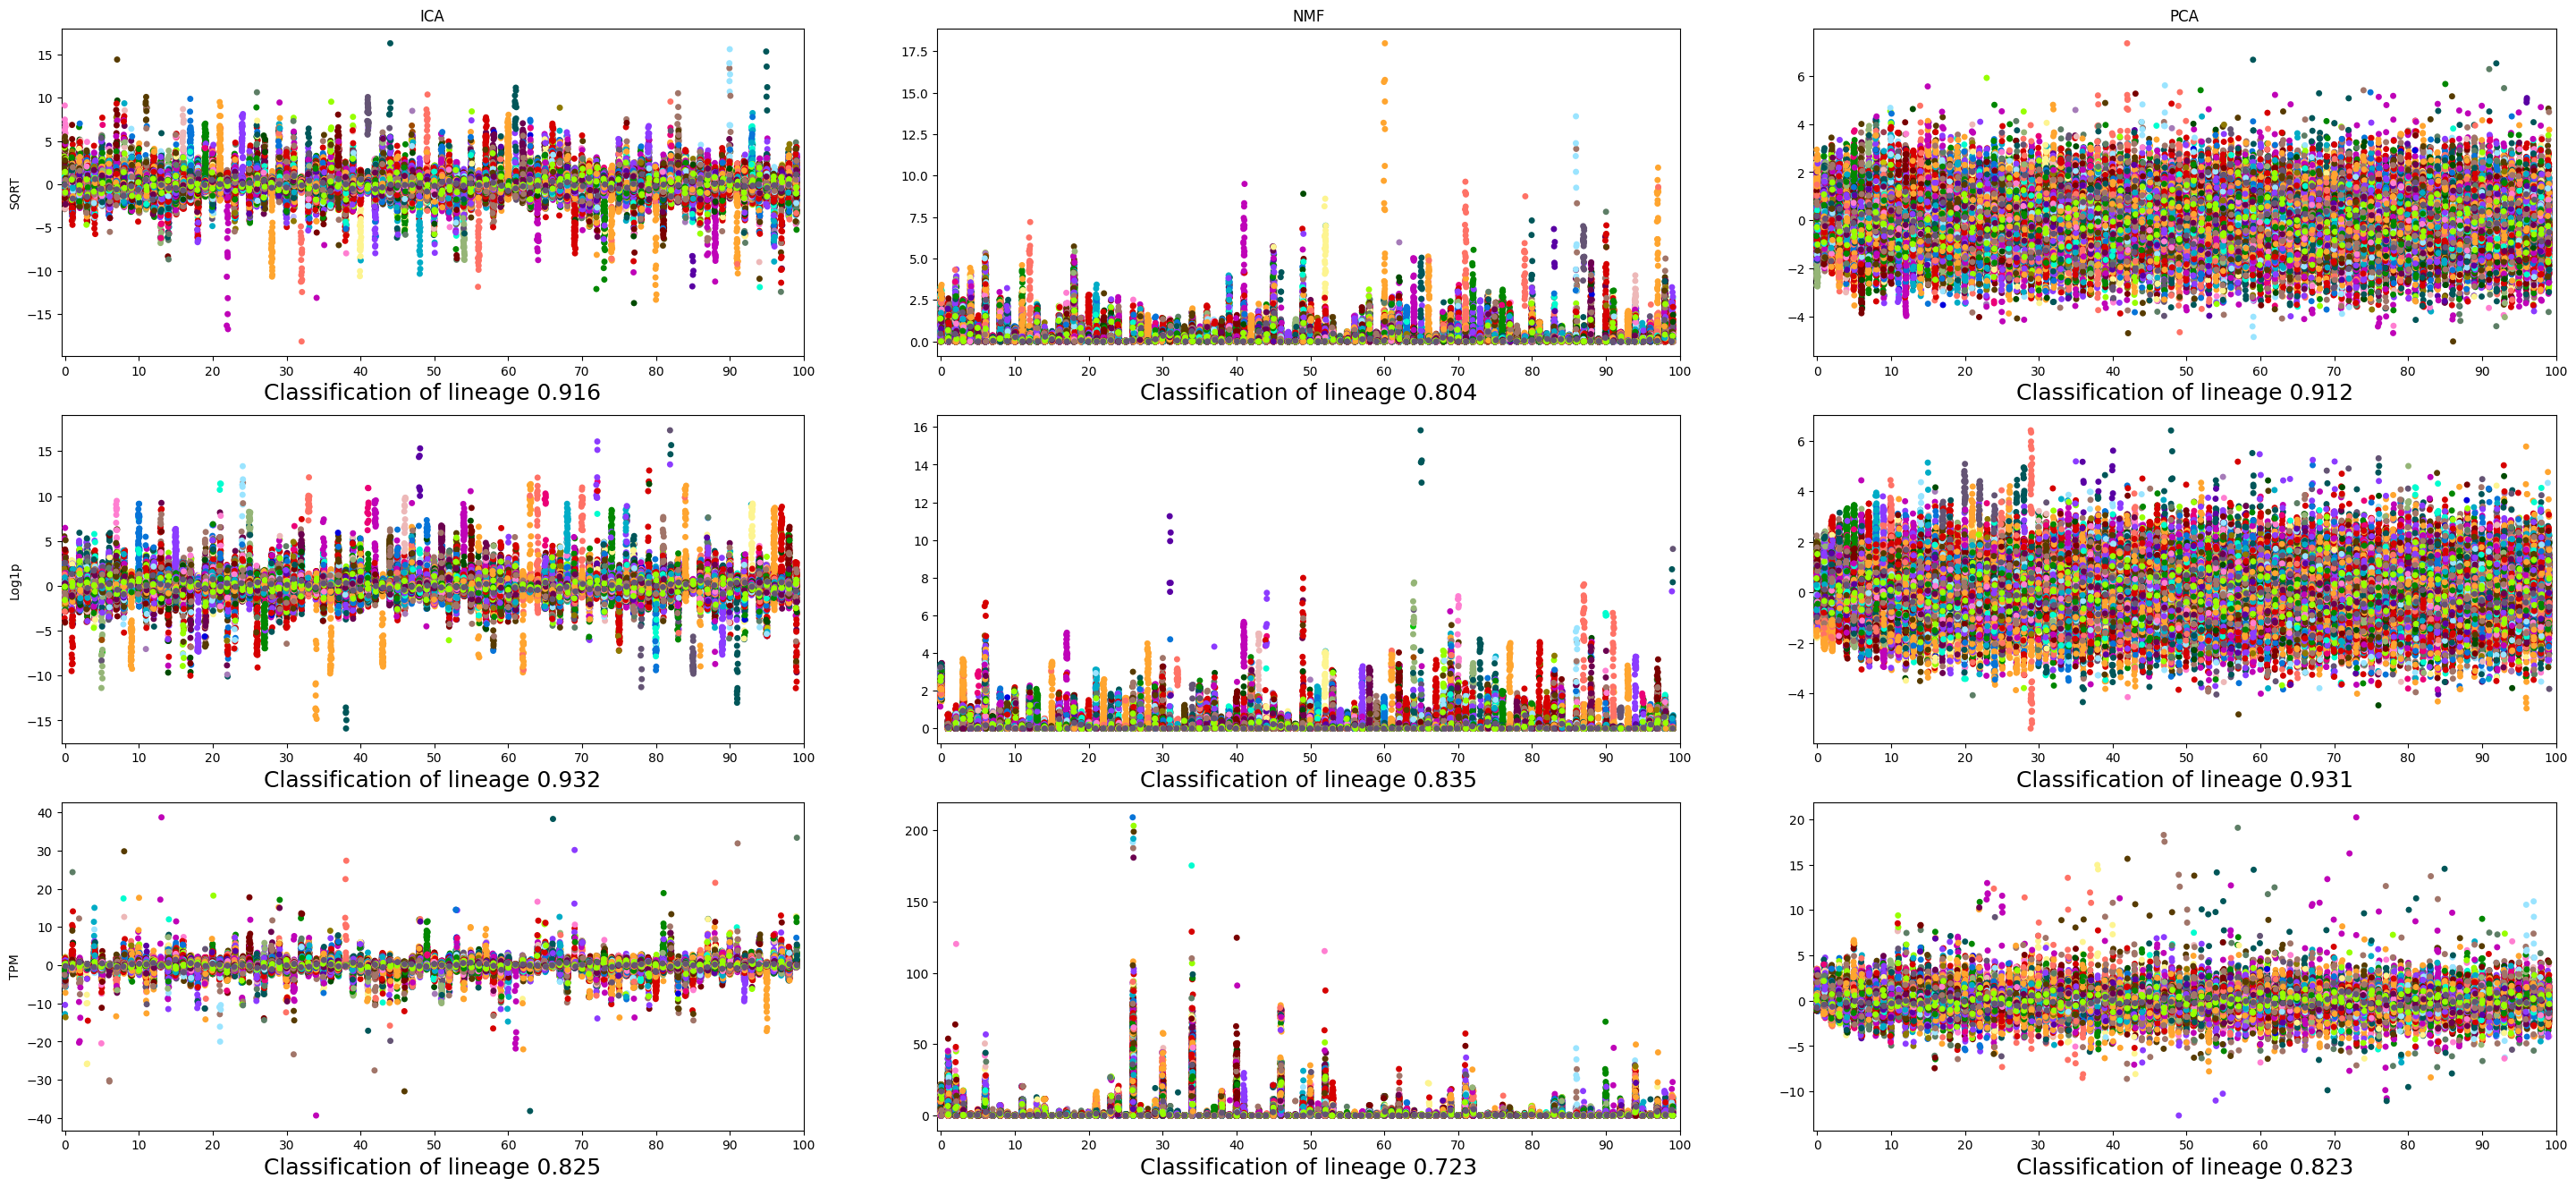

In [34]:
import colorcet as cc
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(36, 16)
ax = ax.flatten()
palette = sns.color_palette(cc.glasbey, n_colors=33)

for index, pat in enumerate(patterns):
    # (normalized expression, 3 factorization methods)
    pat_df = pd.DataFrame(pat, columns=np.arange(100))
    pat_df.loc[:, "lineage"] = raw_tpm_copy.index.map(model_dataset.OncotreeLineage.to_dict())
    pat_df = pat_df.set_index("lineage")
    sns.stripplot(data=pat_df.melt(ignore_index=False).reset_index(), 
                  legend=False, hue='lineage', x='variable', y='value', 
                  palette=palette, ax=ax[index])
    _ = ax[index].set_xticks(np.arange(0, 105, 10), np.arange(0, 105, 10))
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), 
    #                frameon=False, ncols=3)
    if index % 3 == 0:
        ax[index].set_ylabel(["SQRT", "Log1p", "TPM"][index // 3])
    else:
        ax[index].set_ylabel("")
    ax[index].set_xlabel(f"Classification of lineage {cell_line_classifier_acc[index]:.3f}", y=1.05, fontsize=18)

ax[0].set_title("ICA")
ax[1].set_title("NMF")
ax[2].set_title("PCA")
fig.subplots_adjust(wspace=0.18)
fig.subplots_adjust(hspace=0.18)

In [35]:
patterns = []
amplitudes = []
for norm_gene_expression in [np.log1p(raw_tpm_copy)]:
    ica_model = FastICA(n_components=100,
                        random_state=99,
                        whiten='unit-variance')
    #nmf_model = NMF(n_components=100, init='random',
    #                random_state=99)

    #pca_model = PCA(n_components=100,
    #                random_state=99,
    #                whiten=True)

    ica_X_transformed = ica_model.fit_transform(norm_gene_expression)
    A = ica_model.mixing_

    patterns.append(ica_X_transformed)
    amplitudes.append(A)

    #W = nmf_model.fit_transform(norm_gene_expression)
    #H = nmf_model.components_
    #patterns.append(W)
    #amplitudes.append(H)

    #pattern = pca_model.fit_transform(norm_gene_expression)
    #amplitude = pca_model.components_
    #patterns.append(pattern)
    #amplitudes.append(amplitude)
    ##break

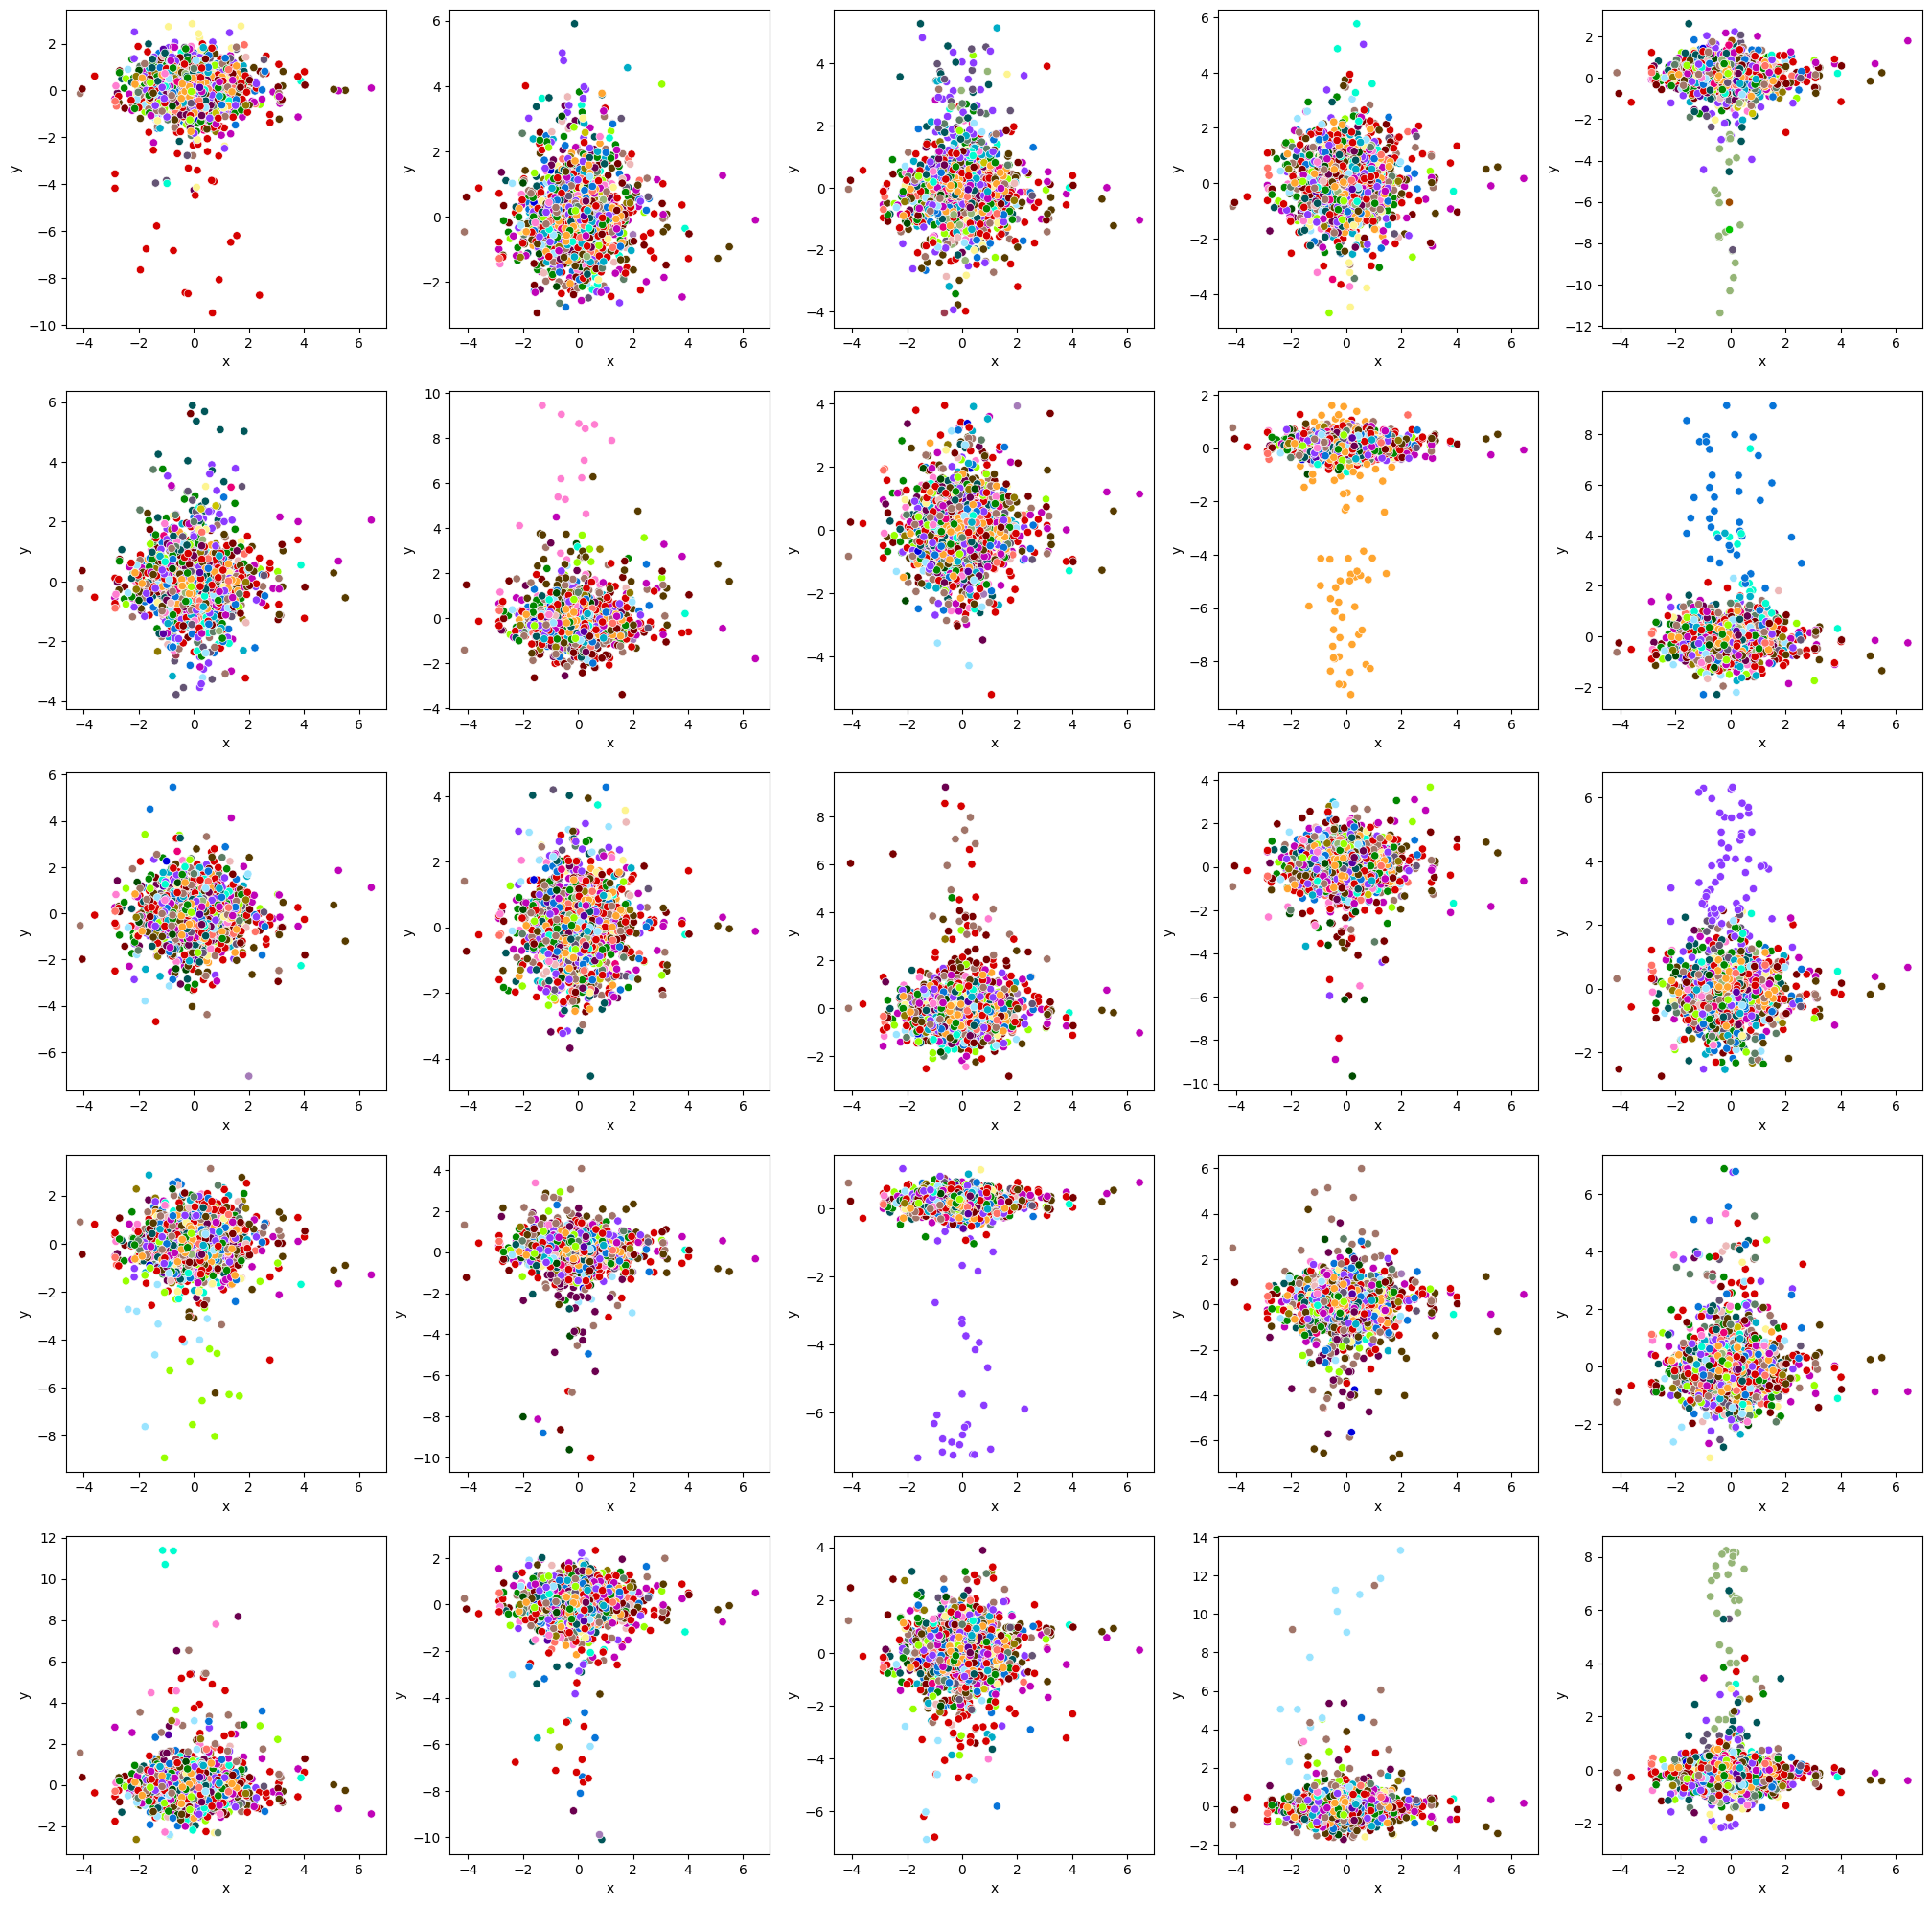

In [36]:
import colorcet as cc
pat = patterns[0]

fig, ax = plt.subplots(5, 5)
fig.set_size_inches(25, 25)
ax = ax.flatten()
n = 0
for i in range(100):
    for j in range(100):
        if i != j:
            if n > 24: break
            pat_df = pd.DataFrame(dict(x=pat[:,i], y=pat[:,j], lineage=raw_tpm_copy.index.map(model_dataset.OncotreeLineage.to_dict())))
            sns.scatterplot(pat_df, x="x", y="y", hue='lineage', ax=ax[n],
                            palette=palette, legend=False)
            n += 1

In [37]:
def write_output(f: str, vals: list):
    with open(f, 'w') as outf:
        for val in vals:
            outf.write(f"{val}\n")

In [51]:
raw_tpm_copy.head()

TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
ACH-001113      17.416861      0.000041   159.931814       5.158212   
ACH-001289      21.398286      0.555614   117.522439       4.786898   
ACH-001339       9.076940      0.000027   152.998605       4.643071   
ACH-001979      23.363881      0.000338    60.591167       5.066298   
ACH-002438      16.642060      0.000154    97.330763       3.511509   

            C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  \
ACH-001113         19.332535    0.017263    1.058297      6.305254   
ACH-001289          9.938277    0.000043    0.157840     12.450694   
ACH-001339         19.728055    0.034067    1.817992     97.476120   
ACH-001979          3.636843    0.000338  161.769723     71.508057   
ACH-002438          7.582847    0.000154    3.686213    107.925560   

            GCLC (2729)  NFYA (4800)  ...  H3C2 (8358)  H3C3 (8352)  \
ACH-001113    88.032396    23.905696  ...     4.807608     0.094461   
ACH-001289    16.719879     9.792638  ...     1.504714     1.152850   
ACH-001339    13.364847     9.905601  ...     0.624040     1.391008   
ACH-001979    29.610335     9.312575  ...     0.000338     0.000338   
ACH-002438     9.365751    20.012370  ...     0.247008     0.387820   

            AC098582.1 (8916)  DUS4L-BCAP29 (115253422)  \
ACH-001113           0.102677                  2.839342   
ACH-001289           0.279160                  1.812299   
ACH-001339           0.958446                  7.697868   
ACH-001979           1.785866                  4.444425   
ACH-002438           0.603535                  2.453337   

            C8orf44-SGK3 (100533105)  ELOA3B (728929)  NPBWR1 (2831)  \
ACH-001113                  0.351378         0.000041       0.152722   
ACH-001289                  0.606534         0.000043       0.016418   
ACH-001339                  0.469391         0.000027       0.057770   
ACH-001979                  0.405024         0.000338       0.045983   
ACH-002438                  0.906495         0.000154       0.036960   

            ELOA3D (100506888)  ELOA3 (162699)  CDR1 (1038)  
ACH-001113            0.000041        0.000041     0.000041  
ACH-001289            0.000043        0.000043     0.000043  
ACH-001339            0.000027        0.000027     0.028497  
ACH-001979            0.000338        0.000338     0.000338  
ACH-002438            0.000154        0.000154     0.062401  

[5 rows x 19193 columns]

In [38]:
amp = amplitudes[0]
amp_df  = pd.DataFrame(amp, index=raw_tpm_copy.columns)

for comp in amp_df.columns:
    sort_vals = amp_df.loc[:, comp].sort_values()
    write_output(f"{comp}_neg.txt", list(sort_vals.head(200).index.map(lambda x:x.split()[0]).values))
    write_output(f"{comp}_pos.txt", list(sort_vals.tail(200).index.map(lambda x:x.split()[0]).values))

In [39]:
from scipy.stats import skewtest

In [40]:
pat_df = pd.DataFrame(pat, columns=np.arange(100))
greater_skewnewss = pat_df.apply(lambda a: skewtest(a, alternative='greater').pvalue, axis=0)
less_skewnewss = pat_df.apply(lambda a: skewtest(a, alternative='less').pvalue, axis=0)

In [41]:
skewness = np.zeros(len(greater_skewnewss))
skewness[greater_skewnewss <= 1e-3] = 1
skewness[less_skewnewss <= 1e-3] = -1

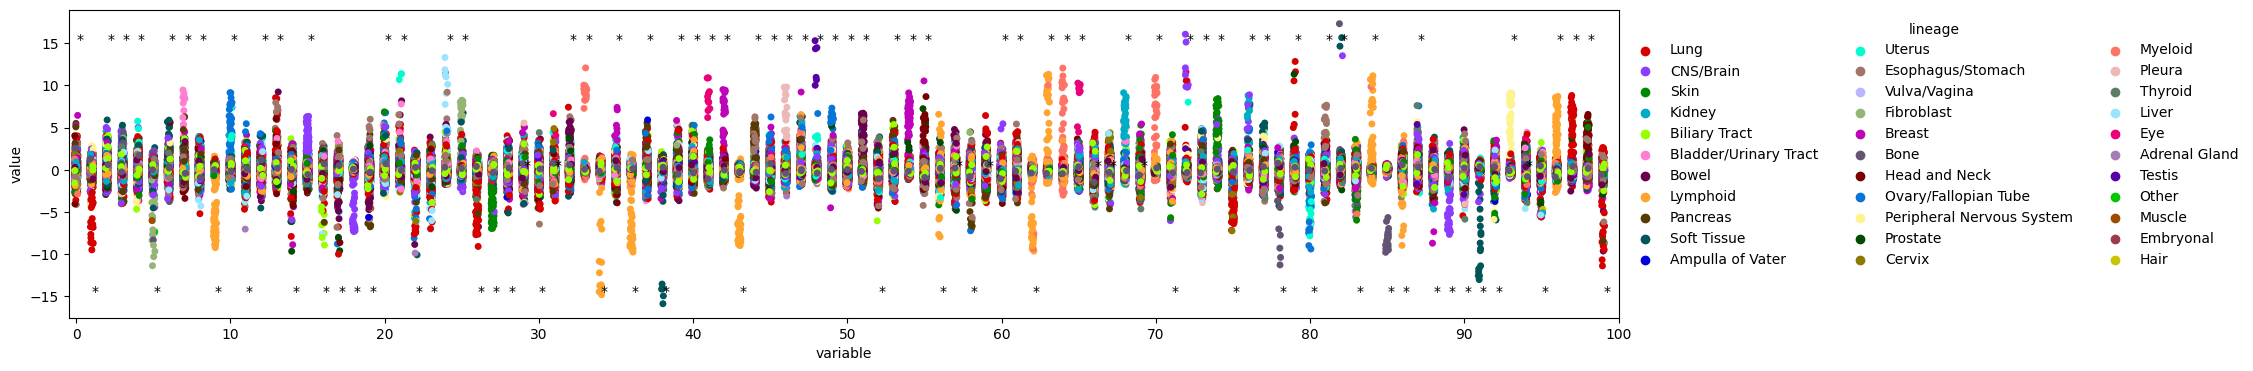

In [42]:
pat_df = pd.DataFrame(pat, columns=np.arange(100))
pat_df.loc[:, "lineage"] = raw_tpm_copy.index.map(model_dataset.OncotreeLineage.to_dict())
pat_df = pat_df.set_index("lineage")
fig, ax = plt.subplots()
fig.set_size_inches(20, 4)

sns.stripplot(data=pat_df.melt(ignore_index=False).reset_index(), 
              legend='brief', hue='lineage', x='variable', y='value', 
              palette=palette, ax=ax)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), 
                frameon=False, ncols=3)

_ = ax.set_xticks(np.arange(0, 105, 10), np.arange(0, 105, 10))
for i, j in zip(np.arange(0, 100), skewness*15):
    ax.text(i, j, "*")

In [43]:
df_gene_effect.loc[:, 'lineage'] = df_gene_effect.index.map(model_dataset.OncotreeLineage.to_dict())

<Axes: xlabel='lineage', ylabel='ZFX'>

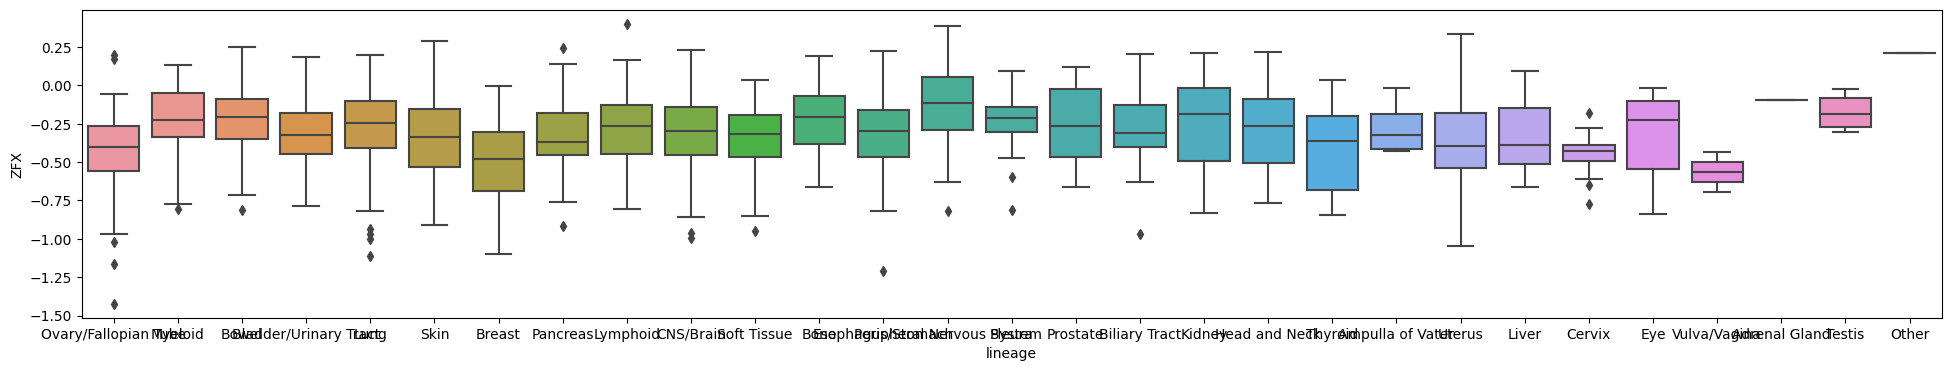

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 4)
target = 'ZFX'
sns.boxplot(df_gene_effect.loc[:, ['lineage', target]], x='lineage', y=target, ax=ax)

In [49]:
amp_df

0         1         2         3         4   \
TSPAN6 (7105)       0.023468  0.088846  0.027780  0.026213 -0.057435   
TNMD (64102)       -0.014922 -0.004374  0.009466 -0.004266 -0.005657   
DPM1 (8813)        -0.005161  0.034700 -0.042750 -0.000732 -0.042004   
SCYL3 (57147)      -0.017411  0.021183 -0.019734 -0.044672 -0.021400   
C1orf112 (55732)   -0.073227  0.019166 -0.057399 -0.015286 -0.005898   
...                      ...       ...       ...       ...       ...   
ELOA3B (728929)     0.000362 -0.000836 -0.000409 -0.000424  0.002921   
NPBWR1 (2831)      -0.000419  0.001207 -0.013903  0.020467 -0.012676   
ELOA3D (100506888)  0.002395 -0.000275 -0.001323 -0.000509  0.002303   
ELOA3 (162699)      0.000837  0.000348  0.000263 -0.001026  0.003430   
CDR1 (1038)        -0.004813 -0.002293  0.006497  0.010287 -0.007014   

                          5         6         7         8         9   ...  \
TSPAN6 (7105)       0.024877  0.025155  0.142361 -0.054605  0.323552  ...   
TNMD (64102)        0.014626  0.001917 -0.004195  0.007003  0.008532  ...   
DPM1 (8813)         0.040974  0.046274  0.036619 -0.026128  0.040702  ...   
SCYL3 (57147)       0.013451  0.025308  0.033507  0.018683 -0.062535  ...   
C1orf112 (55732)    0.082798 -0.008958  0.003979 -0.032933 -0.049690  ...   
...                      ...       ...       ...       ...       ...  ...   
ELOA3B (728929)     0.000518 -0.000297 -0.001078  0.001048 -0.020518  ...   
NPBWR1 (2831)       0.014719 -0.006016  0.037596  0.010178  0.018040  ...   
ELOA3D (100506888)  0.000536 -0.001007 -0.001256  0.000640 -0.013290  ...   
ELOA3 (162699)      0.000895 -0.000957 -0.000223  0.000506 -0.024246  ...   
CDR1 (1038)        -0.010694  0.009447 -0.004920 -0.003500  0.003179  ...   

                          90        91        92        93        94  \
TSPAN6 (7105)      -0.021405 -0.039747 -0.013670 -0.048191  0.029679   
TNMD (64102)        0.009214 -0.008964  0.001889 -0.000408  0.009872   
DPM1 (8813)        -0.012718 -0.034301  0.011859 -0.032715  0.039616   
SCYL3 (57147)       0.008988  0.003647  0.023868  0.008228 -0.018704   
C1orf112 (55732)    0.092680 -0.040071  0.015881  0.003176 -0.029814   
...                      ...       ...       ...       ...       ...   
ELOA3B (728929)     0.001417  0.000495  0.001289 -0.000738  0.000325   
NPBWR1 (2831)      -0.026638  0.016910  0.005936 -0.026854 -0.023155   
ELOA3D (100506888)  0.002122 -0.000544  0.001613  0.000414  0.000931   
ELOA3 (162699)      0.000222  0.000620  0.001215 -0.000664 -0.001404   
CDR1 (1038)         0.003351  0.000999 -0.005552  0.018166  0.004506   

                          95        96        97        98        99  
TSPAN6 (7105)      -0.004868 -0.273631 -0.041932  0.044702  0.136950  
TNMD (64102)        0.011261 -0.005450 -0.012673 -0.005170  0.014175  
DPM1 (8813)        -0.046346 -0.018021 -0.047728  0.048796  0.047058  
SCYL3 (57147)      -0.014176  0.064948 -0.039923 -0.004965 -0.014228  
C1orf112 (55732)   -0.126692  0.068313  0.037638 -0.021003  0.014457  
...                      ...       ...       ...       ...       ...  
ELOA3B (728929)     0.001134  0.006833  0.001005 -0.002435 -0.000719  
NPBWR1 (2831)       0.013575 -0.041752  0.011125  0.082391  0.003664  
ELOA3D (100506888)  0.001521  0.003208  0.000589 -0.002019 -0.000814  
ELOA3 (162699)      0.001562  0.012508  0.006730 -0.002011 -0.000597  
CDR1 (1038)        -0.005395 -0.001820 -0.004752 -0.006516  0.004053  

[19193 rows x 100 columns]

In [50]:
comp_gene_effect

A1BG      -0.039555
A1CF      -0.042952
A2M        0.027490
A2ML1      0.055658
A3GALT2   -0.099776
             ...   
ZYG11A    -0.026470
ZYG11B    -0.220291
ZYX       -0.011641
ZZEF1     -0.136596
ZZZ3      -0.306414
Length: 18443, dtype: float64

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_10129/741750009.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  comp_gene_effect = df_gene_effect.loc[df_gene_effect['lineage'] == 'Lung', :].mean(axis=0)
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/numpy/lib/histograms.py:1065: RuntimeWarning: invalid value encountered in divide
  hist /= s


ValueError: zero-size array to reduction operation minimum which has no identity

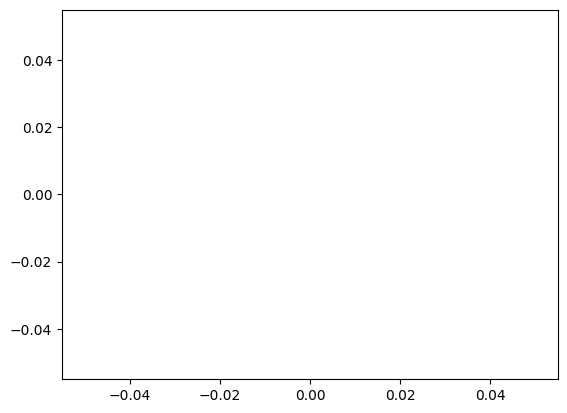

In [46]:
from cds import plotting

comp_gene_effect = df_gene_effect.loc[df_gene_effect['lineage'] == 'Lung', :].mean(axis=0)
comp_gene_amp = amp_df.iloc[:, [1]].merge(pd.DataFrame(comp_gene_effect), left_index=True, right_index=True)
plotting.density_scatter(comp_gene_amp.iloc[:, 0], comp_gene_amp.iloc[:, 1])
plt.title("Component 1")
plt.xlabel("Component gene score")
plt.ylabel("Lung average CRISPR gene effect ")

In [48]:
comp_gene_amp

Empty DataFrame
Columns: [1, 0]
Index: []

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_5887/3738996077.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  comp_gene_effect = df_gene_effect.loc[df_gene_effect['lineage'] == 'Lymphoid', :].mean(axis=0)


Text(0, 0.5, 'Lung average CRISPR gene effect ')

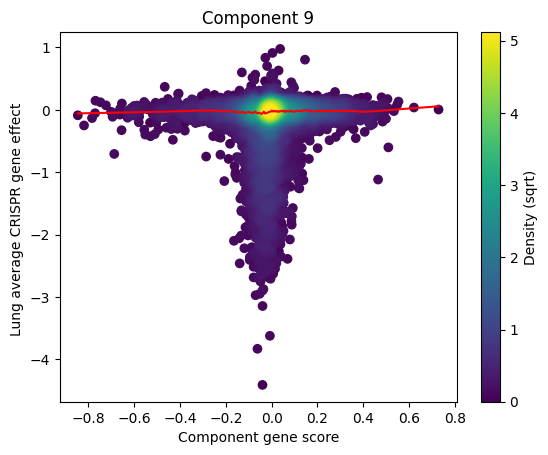

In [ ]:
from cds import plotting

comp_gene_effect = df_gene_effect.loc[df_gene_effect['lineage'] == 'Lymphoid', :].mean(axis=0)
comp_gene_amp = amp_df.iloc[:, [9]].merge(pd.DataFrame(comp_gene_effect), left_index=True, right_index=True)
plotting.density_scatter(comp_gene_amp.iloc[:, 0], comp_gene_amp.iloc[:, 1])
plt.title("Component 9")
plt.xlabel("Component gene score")
plt.ylabel("Lung average CRISPR gene effect ")

In [ ]:
lisa_all = []
for direction in ['pos', 'neg']:
    for comp_i in range(0, 100):
        lisa_result = pd.read_table(f"data{comp_i}_{direction}.txt.lisa.tsv")
        lisa_result.drop_duplicates(['factor', 'cell_line'], inplace=True)

        lisa_result.loc[:, "component"] = comp_i
        direction_label = +1 if direction == "pos" else -1
        lisa_result.loc[:, "gene_loadings_direction"] = direction_label
        lisa_result.loc[:, "lineage_skewness"] = skewness[comp_i]
        inferred_lineage = pat_df.iloc[:, comp_i].sort_values(ascending=True)

        if skewness[comp_i] == -1:
            inferred_lineage = ','.join(map(str, list(inferred_lineage.index[:10])))

        if skewness[comp_i] == +1:
            inferred_lineage = ','.join(map(str, list(inferred_lineage.index[-10:])))

        if skewness[comp_i] == 0:
            inferred_lineage = "NotSignificant"

        lisa_result.loc[:, 'inferred_lineage'] = inferred_lineage
        lisa_all.append(lisa_result.head(20))

corrs_dfs_merged = pd.concat(lisa_all, axis=0)
corrs_dfs_merged.to_csv(f"lisa_top20_results_correlation.tsv", sep="\t")

In [ ]:
%pwd

In [ ]:
df_gene_effect.columns = df_gene_effect.columns.map(lambda x: x.split()[0])

In [ ]:
all_top_20_overlap_crispr_genes = np.unique(np.intersect1d(corrs_dfs_merged.factor.unique(), df_gene_effect.columns))

In [ ]:
all_top_20_overlap_crispr_genes.shape

(345,)

<Axes: ylabel='lineage'>

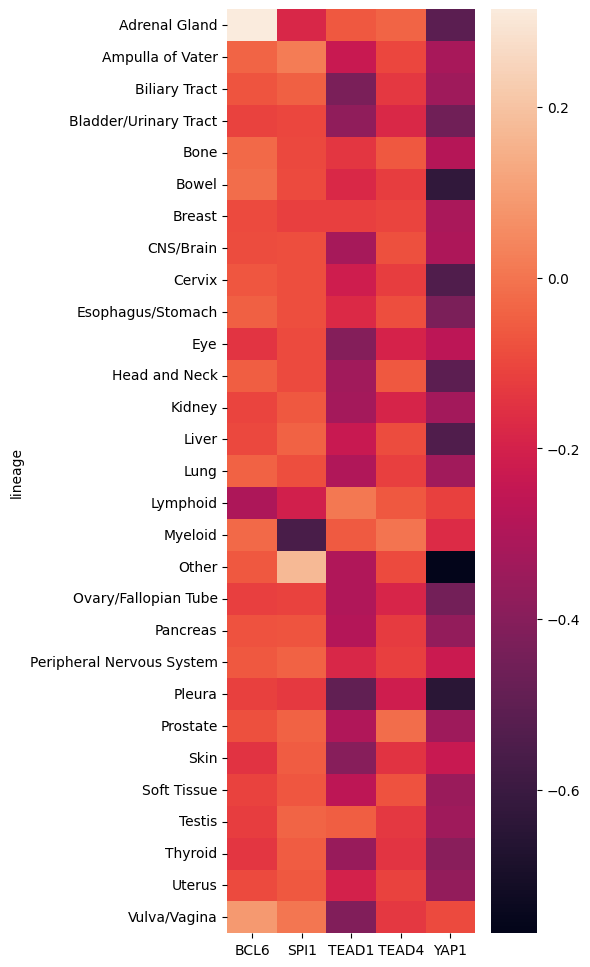

In [ ]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(4, 12)
sns.heatmap(df_gene_effect.loc[:, ["BCL6", "SPI1", "TEAD1", "TEAD4", "YAP1", "lineage"]].groupby("lineage").mean(), ax=ax)

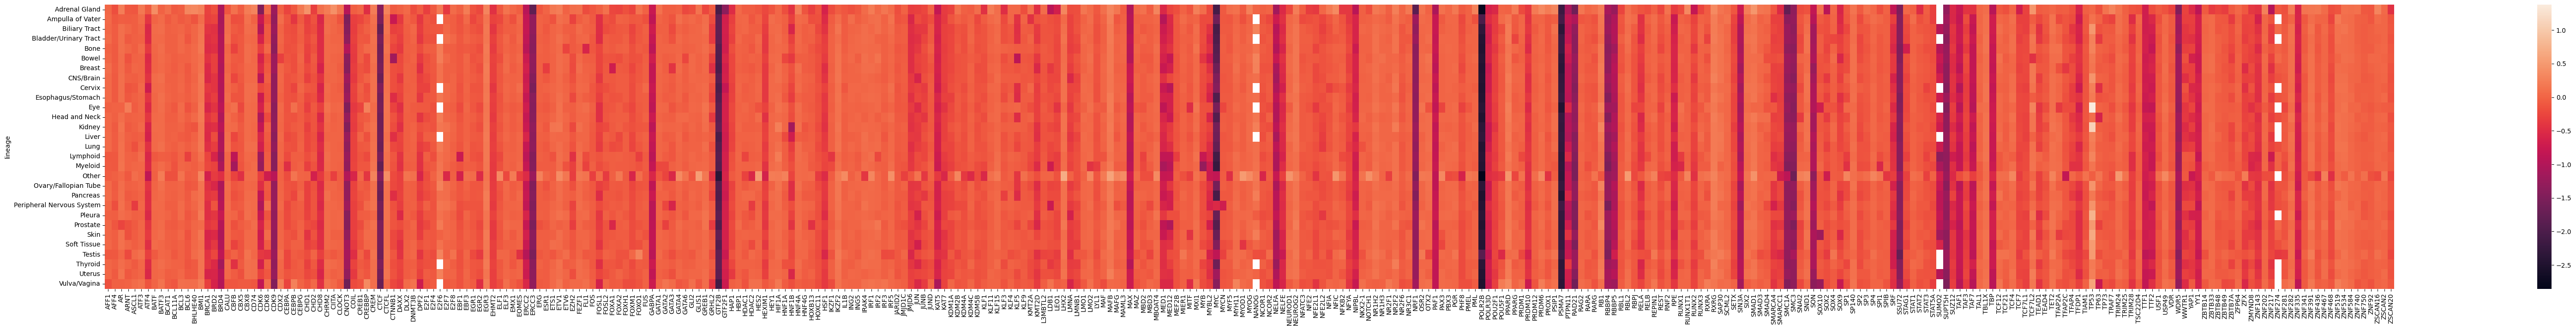

In [ ]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(80, 8)
sns.heatmap(df_gene_effect.loc[:, list(all_top_20_overlap_crispr_genes)+['lineage']].groupby("lineage").mean(), ax=ax)
plt.savefig("lineage_average_gene_effect.pdf")

In [ ]:
%pwd

'/home/ubuntu/depmap_omics/ccle_tasks'

In [ ]:
all_top_20_overlap_crispr_genes.shape, corrs_dfs_merged.factor.unique().shape

((345,), (361,))

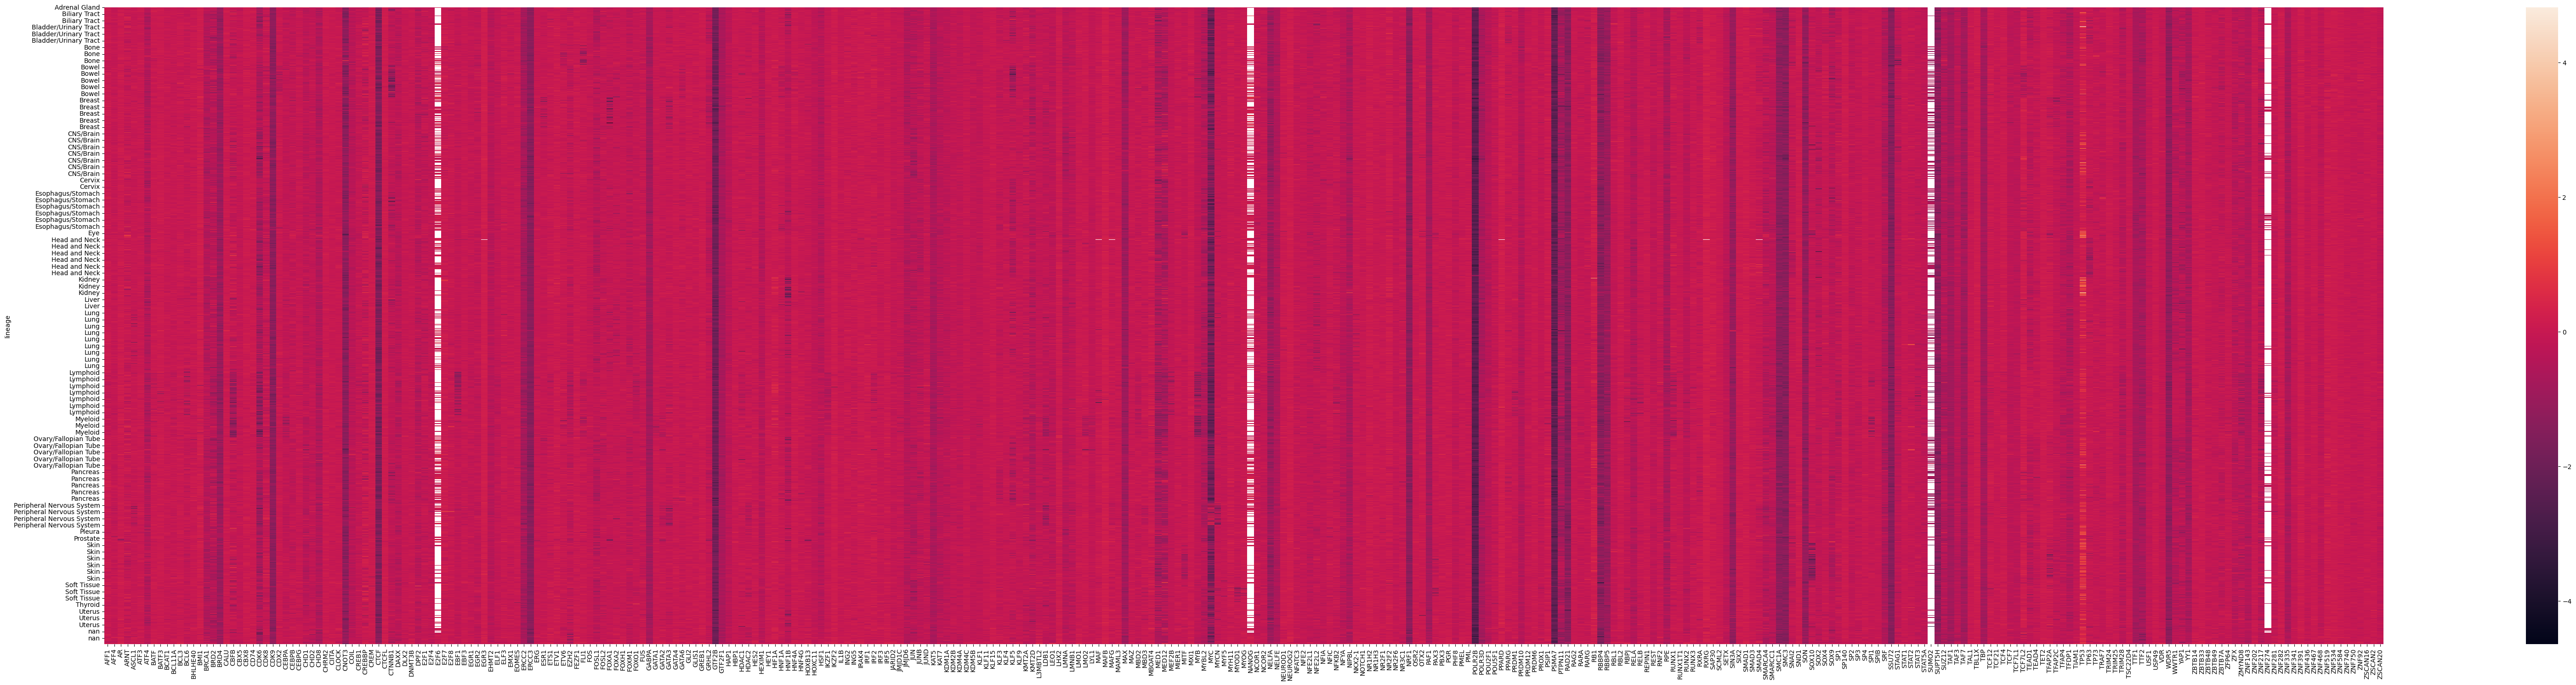

In [ ]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(80, 18)
sns.heatmap(df_gene_effect.loc[:, list(all_top_20_overlap_crispr_genes)+['lineage']].set_index("lineage").sort_index(), ax=ax)
plt.savefig("cell_line_gene_effect.pdf")

In [ ]:
import os
import pandas as pd
import glob
tsvs = glob.glob("/home/ubuntu/streme/ACH*streme/*tsv")
tsv_dfs = []
for ach in tsvs:
    tsv = pd.read_table(ach, skipfooter=3)
    ach = os.path.basename(os.path.dirname(ach)).split("_")[0]
    if tsv.shape[0] == 0: continue
    tsv.loc[:, 'ACH'] = ach
    tsv_dfs.append(tsv)

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9471/4293129376.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  tsv = pd.read_table(ach, skipfooter=3)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9471/4293129376.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  tsv = pd.read_table(ach, skipfooter=3)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9471/4293129376.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  tsv = pd.read_table(ach, skipfooter=3)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9471/4293129376.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not

In [ ]:
tsv_dfs = pd.concat(tsv_dfs, axis=0)
tsv_dfs.loc[:, 'lineage'] = tsv_dfs.ACH.map(model_dataset.OncotreeLineage.to_dict())
#This is the p-value of the motif according to the SEA motif enrichment analysis program. The RANK of the motif is based on this value. This is NOT an accurate measure of the statistical significance of the motif because it is not adjusted for multiple tests. SEA estimates the p-value of motifs using either the Fisher exact test or the Binomial test, as is described here.
tsv_dfs_filtered = tsv_dfs.loc[tsv_dfs.SEA_PVALUE <= 1e-2, :]

In [ ]:
tsv_dfs_filtered.loc[~tsv_dfs_filtered.SIM_SOURCE.isin(["MEME", "STREME"]), :].loc[:, ['SEA_PVALUE', 'SIM_MOTIF', 'ACH', 'lineage']].head()

SEA_PVALUE              SIM_MOTIF         ACH    lineage
0  1.840000e-08  PITX2_HUMAN.H11MO.0.D  ACH-000445  CNS/Brain
1  1.840000e-08  ZN770_HUMAN.H11MO.0.C  ACH-000445  CNS/Brain
2  1.200000e-06   OSR2_HUMAN.H11MO.0.C  ACH-000445  CNS/Brain
3  1.610000e-06  THA11_HUMAN.H11MO.0.B  ACH-000445  CNS/Brain
4  4.070000e-06  ZN770_HUMAN.H11MO.0.C  ACH-000445  CNS/Brain

In [ ]:
motifs_mat = tsv_dfs_filtered.loc[~tsv_dfs_filtered.SIM_SOURCE.isin(["MEME", "STREME"]), :].loc[:, ['SEA_PVALUE', 'SIM_MOTIF', 'ACH', 'lineage']].groupby(["lineage", "SIM_MOTIF"]).min("SEA_PVALUE").unstack()

In [ ]:
motifs_mat.head()

SEA_PVALUE                                            \
SIM_MOTIF      ALX1_HUMAN.H11MO.0.B ANDR_HUMAN.H11MO.0.A AP2A_HUMAN.H11MO.0.A   
ACH                                                                             
BladderUrinary                  NaN                  NaN                  NaN   
Bone                            NaN                  NaN                  NaN   
Bowel                           NaN                  NaN                  NaN   
Breast                 9.260000e-07                  NaN             0.000016   
CNSBrain                        NaN             0.000009                  NaN   

                                                          \
SIM_MOTIF      AP2C_HUMAN.H11MO.0.A AP2D_HUMAN.H11MO.0.D   
ACH                                                        
BladderUrinary                  NaN         2.980000e-06   
Bone                            NaN                  NaN   
Bowel                           NaN                  NaN   
Breast                 7.870000e-12         2.160000e-15   
CNSBrain                        NaN         1.030000e-10   

                                                            \
SIM_MOTIF      ARI3A_HUMAN.H11MO.0.D ARNT2_HUMAN.H11MO.0.D   
ACH                                                          
BladderUrinary                   NaN                   NaN   
Bone                             NaN          5.620000e-06   
Bowel                            NaN                   NaN   
Breast                      0.000003          8.400000e-27   
CNSBrain                    0.000011          1.290000e-22   

                                                           \
SIM_MOTIF      ASCL1_HUMAN.H11MO.0.A ATF2_HUMAN.H11MO.0.B   
ACH                                                         
BladderUrinary                   NaN                  NaN   
Bone                             NaN         2.500000e-07   
Bowel                       0.000013                  NaN   
Breast                           NaN                  NaN   
CNSBrain                         NaN                  NaN   

                                     ...                        \
SIM_MOTIF      ATF2_HUMAN.H11MO.2.C  ... ZN708_HUMAN.H11MO.1.D   
ACH                                  ...                         
BladderUrinary                  NaN  ...                   NaN   
Bone                            NaN  ...                   NaN   
Bowel                           NaN  ...                   NaN   
Breast                          NaN  ...                   NaN   
CNSBrain               3.340000e-10  ...                   NaN   

                                                            \
SIM_MOTIF      ZN740_HUMAN.H11MO.0.D ZN768_HUMAN.H11MO.0.C   
ACH                                                          
BladderUrinary                   NaN                   NaN   
Bone                    8.210000e-07                   NaN   
Bowel                            NaN                   NaN   
Breast                           NaN                   NaN   
CNSBrain                         NaN          1.920000e-17   

                                                            \
SIM_MOTIF      ZN770_HUMAN.H11MO.0.C ZN770_HUMAN.H11MO.1.C   
ACH                                                          
BladderUrinary          3.400000e-22          1.930000e-23   
Bone                    7.400000e-25          3.530000e-09   
Bowel                   2.640000e-26          6.210000e-11   
Breast                  1.120000e-55          2.460000e-59   
CNSBrain                2.100000e-39          4.590000e-44   

                                                            \
SIM_MOTIF      ZN784_HUMAN.H11MO.0.D ZNF76_HUMAN.H11MO.0.C   
ACH                                                          
BladderUrinary              0.000062                   NaN   
Bone                             NaN          3.030000e-06   
Bowel                            NaN          5.350000e-06   
Breast        

In [ ]:
motifs_mat.loc[:, motifs_mat.columns.get_level_values(1).str.contains("FOXA1_")]

SEA_PVALUE
SIM_MOTIF        FOXA1_HUMAN.H11MO.0.A
ACH                                   
BladderUrinary                     NaN
Bone                               NaN
Bowel                     3.350000e-05
Breast                    3.570000e-13
CNSBrain                           NaN
EsophagusStomach                   NaN
Head                               NaN
Kidney                             NaN
Liver                              NaN
Lung                      3.080000e-10
Other                              NaN
OvaryFallopian                     NaN
Pancreas                           NaN
Skin                               NaN
Uterus                             NaN

In [ ]:
motifs_mat.loc[:, motifs_mat.columns.get_level_values(1).str.contains("ESR1")]

SEA_PVALUE                     
SIM_MOTIF                 ESR1_HUMAN.H11MO.0.A ESR1_HUMAN.H11MO.1.A
lineage                                                            
Ampulla of Vater                           NaN                  NaN
Biliary Tract                              NaN         5.440000e-05
Bladder/Urinary Tract             1.320000e-05                  NaN
Bone                                       NaN                  NaN
Bowel                             7.740000e-08                  NaN
Breast                                     NaN                  NaN
CNS/Brain                                  NaN         2.370000e-07
Esophagus/Stomach                 5.860000e-06                  NaN
Head and Neck                     2.960000e-04                  NaN
Kidney                            3.560000e-05                  NaN
Liver                                      NaN         1.430000e-05
Lung                              3.320000e-09         2.220000e-07
Myeloid                                    NaN                  NaN
Ovary/Fallopian Tube                       NaN         1.280000e-05
Pancreas                          1.130000e-05                  NaN
Peripheral Nervous System                  NaN                  NaN
Pleura                                     NaN                  NaN
Prostate                          2.350000e-07         3.600000e-07
Skin                              8.810000e-03         2.960000e-05
Soft Tissue                                NaN         7.130000e-09
Thyroid                                    NaN         4.820000e-05
Uterus                                     NaN                  NaN

In [ ]:
import os
import glob
tsvs = glob.glob("/home/ubuntu/streme/lineage*streme/*tsv")
tsv_dfs = []
for ach in tsvs:
    tsv = pd.read_table(ach, skipfooter=3)
    ach = os.path.basename(os.path.dirname(ach)).split("_")[1]
    if tsv.shape[0] == 0: continue
    tsv.loc[:, 'ACH'] = ach
    tsv_dfs.append(tsv)

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9471/901591055.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  tsv = pd.read_table(ach, skipfooter=3)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9471/901591055.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  tsv = pd.read_table(ach, skipfooter=3)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9471/901591055.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  tsv = pd.read_table(ach, skipfooter=3)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9471/901591055.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not sup

In [ ]:
tsv_dfs = pd.concat(tsv_dfs, axis=0)
tsv_dfs.head()

RANK  SEED_MOTIF  CLUSTER  SOURCE                 ID    ALT_ID  \
0     1           1        1    MEME    GGAGGCTGAGGYRGG    MEME-1   
1     2           1        2  STREME     1-TCTCTACWAAAA  STREME-1   
2     3           1        3    MEME    CCACCRYGCCYRGCT    MEME-7   
3     4           0        1  STREME  2-GAGGCTGAGGCAGGA  STREME-2   
4     5           1        4    MEME    AGCTGGGAYTACAGG    MEME-2   

         CONSENSUS  WIDTH  SITES    SEA_PVALUE         EVALUE  EVALUE_ACC  \
0  GGAGGCTGAGGYRGG     15    139  5.820000e-19  2.900000e-112           1   
1     TCTCTACWAAAA     12     79  5.830000e-19   3.880000e-02           1   
2  CCACCRYGCCYRGCT     15     80  2.430000e-18   1.100000e-41           1   
3  GAGGCTGAGGCAGGA     15     73  6.490000e-16   3.880000e-02           1   
4  AGCTGGGAYTACAGG     15     69  9.530000e-16   4.200000e-78           1   

                                          SIM_SOURCE              SIM_MOTIF  \
0  /home/ubuntu/streme/motif_databases/HUMAN/HOCO...  ZN770_HUMAN.H11MO.0.C   
1  /home/ubuntu/streme/motif_databases/HUMAN/HOCO...  HXD13_HUMAN.H11MO.0.D   
2  /home/ubuntu/streme/motif_databases/HUMAN/HOCO...  TBX15_HUMAN.H11MO.0.D   
3  /home/ubuntu/streme/motif_databases/HUMAN/HOCO...  ZN770_HUMAN.H11MO.0.C   
4  /home/ubuntu/streme/motif_databases/HUMAN/HOCO...  PITX2_HUMAN.H11MO.0.D   

                                           MOTIF_URL    ACH  
0  http://hocomoco.autosome.ru/motif/ZN770_HUMAN....  Liver  
1  http://hocomoco.autosome.ru/motif/HXD13_HUMAN....  Liver  
2  http://hocomoco.autosome.ru/motif/TBX15_HUMAN....  Liver  
3  http://hocomoco.autosome.ru/motif/ZN770_HUMAN....  Liver  
4  http://hocomoco.autosome.ru/motif/PITX2_HUMAN....  Liver

In [ ]:
tsv_dfs.to_csv("lineage_motif_scan_atac.tsv", sep='\t')

In [ ]:
%pwd

'/home/ubuntu/depmap_omics/ccle_tasks'

In [ ]:
#This is the p-value of the motif according to the SEA motif enrichment analysis program. The RANK of the motif is based on this value. This is NOT an accurate measure of the statistical significance of the motif because it is not adjusted for multiple tests. SEA estimates the p-value of motifs using either the Fisher exact test or the Binomial test, as is described here.

tsv_dfs_filtered = tsv_dfs.loc[tsv_dfs.SEA_PVALUE <= 1e-2, :]

In [ ]:
tsv_dfs_filtered.loc[~tsv_dfs_filtered.SIM_SOURCE.isin(["MEME", "STREME"]), :].loc[:, ['SEA_PVALUE', 'SIM_MOTIF', 'ACH']].head()

SEA_PVALUE              SIM_MOTIF    ACH
0  5.820000e-19  ZN770_HUMAN.H11MO.0.C  Liver
1  5.830000e-19  HXD13_HUMAN.H11MO.0.D  Liver
2  2.430000e-18  TBX15_HUMAN.H11MO.0.D  Liver
3  6.490000e-16  ZN770_HUMAN.H11MO.0.C  Liver
4  9.530000e-16  PITX2_HUMAN.H11MO.0.D  Liver

In [ ]:
motifs_mat = tsv_dfs_filtered.loc[~tsv_dfs_filtered.SIM_SOURCE.isin(["MEME", "STREME"]), :].loc[:, ['SEA_PVALUE', 'SIM_MOTIF', 'ACH']].groupby(["ACH", "SIM_MOTIF"]).min("SEA_PVALUE").unstack()

In [ ]:
motifs_mat.loc[:, motifs_mat.columns.get_level_values(1).str.contains("ESR1")]

SEA_PVALUE
SIM_MOTIF        ESR1_HUMAN.H11MO.1.A
ACH                                  
BladderUrinary                    NaN
Bone                              NaN
Bowel                             NaN
Breast                       0.000002
CNSBrain                          NaN
EsophagusStomach                  NaN
Head                              NaN
Kidney                            NaN
Liver                             NaN
Lung                              NaN
Other                             NaN
OvaryFallopian                    NaN
Pancreas                          NaN
Skin                              NaN
Uterus                            NaN

In [ ]:
motifs_mat.loc[:, motifs_mat.columns.get_level_values(1).str.contains("ANDR")]

SEA_PVALUE
SIM_MOTIF        ANDR_HUMAN.H11MO.0.A
ACH                                  
BladderUrinary                    NaN
Bone                              NaN
Bowel                             NaN
Breast                            NaN
CNSBrain                     0.000009
EsophagusStomach                  NaN
Head                              NaN
Kidney                            NaN
Liver                             NaN
Lung                              NaN
Other                             NaN
OvaryFallopian                    NaN
Pancreas                          NaN
Skin                         0.000009
Uterus                            NaN

In [ ]:
motifs_mat.loc[:, motifs_mat.columns.get_level_values(1).str.contains("FOXA1_")]

SEA_PVALUE
SIM_MOTIF        FOXA1_HUMAN.H11MO.0.A
ACH                                   
BladderUrinary                     NaN
Bone                               NaN
Bowel                     3.350000e-05
Breast                    3.570000e-13
CNSBrain                           NaN
EsophagusStomach                   NaN
Head                               NaN
Kidney                             NaN
Liver                              NaN
Lung                      3.080000e-10
Other                              NaN
OvaryFallopian                     NaN
Pancreas                           NaN
Skin                               NaN
Uterus                             NaN

In [ ]:
motifs_mat.columns = motifs_mat.columns.get_level_values(1)

In [ ]:
motifs_mat.shape

(15, 313)

In [ ]:
motifs_mat.min(axis=1)

ACH
BladderUrinary      1.930000e-23
Bone                1.010000e-51
Bowel               8.260000e-33
Breast              2.460000e-59
CNSBrain            8.800000e-57
EsophagusStomach    5.270000e-52
Head                2.770000e-23
Kidney              1.600000e-36
Liver               5.820000e-19
Lung                1.040000e-61
Other               5.900000e-53
OvaryFallopian      3.060000e-48
Pancreas            1.210000e-32
Skin                7.780000e-59
Uterus              1.050000e-73
dtype: float64

In [ ]:
motifs_mat.loc["Breast"].dropna().sort_values().head(20)

SIM_MOTIF
ZN770_HUMAN.H11MO.1.C    2.460000e-59
ZN770_HUMAN.H11MO.0.C    1.120000e-55
PITX2_HUMAN.H11MO.0.D    1.380000e-54
ZN121_HUMAN.H11MO.0.C    1.890000e-54
VDR_HUMAN.H11MO.1.A      2.410000e-51
ZN274_HUMAN.H11MO.0.A    1.060000e-45
ZN140_HUMAN.H11MO.0.C    1.850000e-44
TBX15_HUMAN.H11MO.0.D    7.870000e-43
ZN490_HUMAN.H11MO.0.C    3.420000e-42
HXD13_HUMAN.H11MO.0.D    7.050000e-38
PAX5_HUMAN.H11MO.0.A     5.640000e-37
VSX2_HUMAN.H11MO.0.D     2.500000e-32
CPEB1_HUMAN.H11MO.0.D    4.020000e-28
ARNT2_HUMAN.H11MO.0.D    8.400000e-27
FOSB_HUMAN.H11MO.0.A     4.530000e-16
AP2D_HUMAN.H11MO.0.D     2.160000e-15
ESR2_HUMAN.H11MO.1.A     3.840000e-15
MAZ_HUMAN.H11MO.0.A      7.480000e-15
WT1_HUMAN.H11MO.0.C      1.320000e-14
ZN263_HUMAN.H11MO.0.A    1.550000e-14
Name: Breast, dtype: float64